In [1]:
install.packages('dslabs')
install.packages('matrixStats')
install.packages('ggplot2')
install.packages('e1071')
install.packages('caret')
install.packages('Rborist')
install.packages('randomForest')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependency ‘RcppArmadillo’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [2]:
library(dslabs)

In [3]:
mnist <- read_mnist()

In [4]:
names(mnist)
dim(mnist$train$images)
class(mnist$train$labels)
table(mnist$train$labels)

[1] "train" "test"

[1] 60000   784

[1] "integer"


   0    1    2    3    4    5    6    7    8    9 
5923 6742 5958 6131 5842 5421 5918 6265 5851 5949 

In [5]:
set.seed(123)
index <- sample(nrow(mnist$train$images),10000)
x <- mnist$train$images[index,]
y <- factor(mnist$train$labels[index])

index <- sample(nrow(mnist$train$images),1000)
x_test <- mnist$train$images[index,]
y_test <- factor(mnist$train$labels[index])

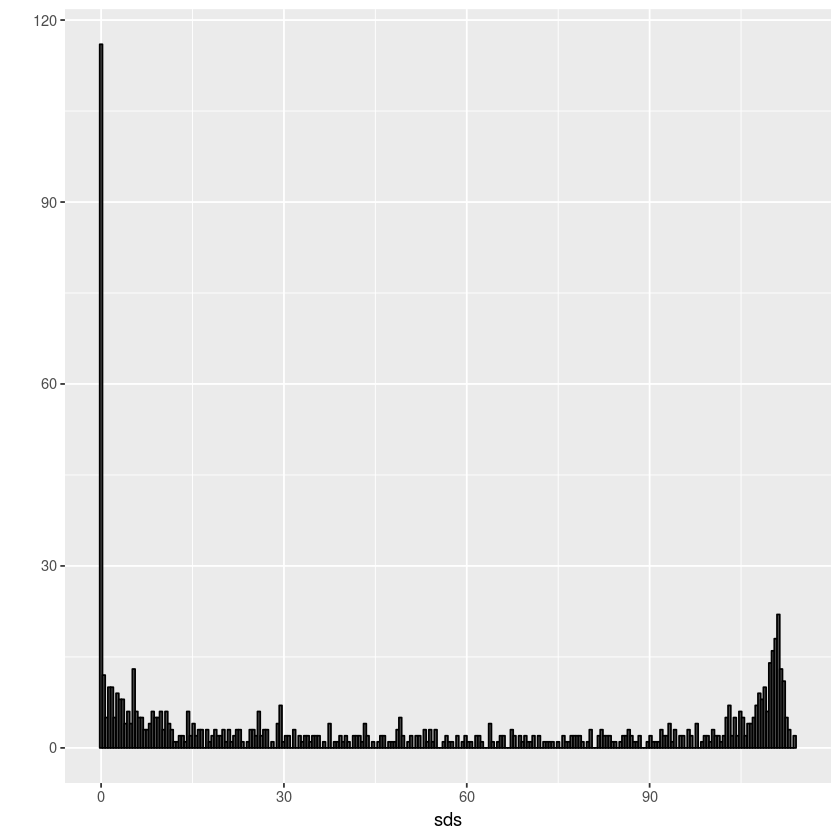

In [6]:
library(matrixStats)
library(ggplot2)

sds <- colSds(x)
qplot(sds, bins = 256, color = I('black'))

In [7]:
library(caret)
nzv <- nearZeroVar(x)


Loading required package: lattice


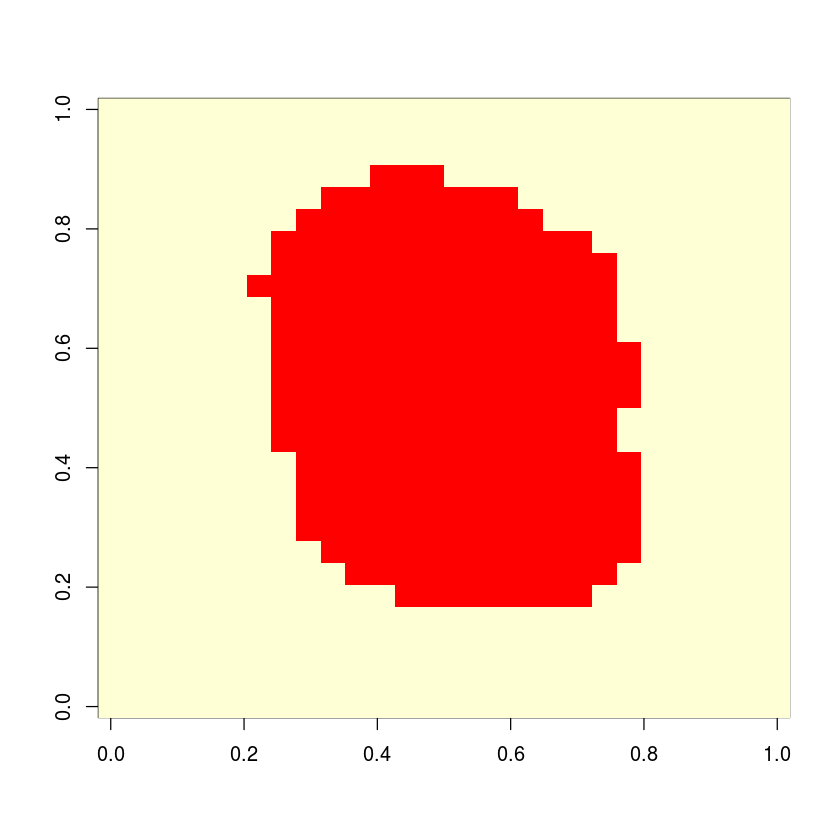

In [8]:
image(matrix(1:784 %in% nzv, 28, 28))

In [9]:
col_index <- setdiff(1:ncol(x),nzv)
length(col_index)

[1] 252

In [10]:
colnames(x) <- 1:ncol(mnist$train$images)
colnames(x_test) <- colnames(mnist$tr)

In [11]:
control <- trainControl(method='cv',number=10,p=0.9)
train_knn <- train(x[,col_index],y,
                  method='knn',
                  tuneGrid=data.frame(k=c(1,3,5,7)),
                  trControl = control)

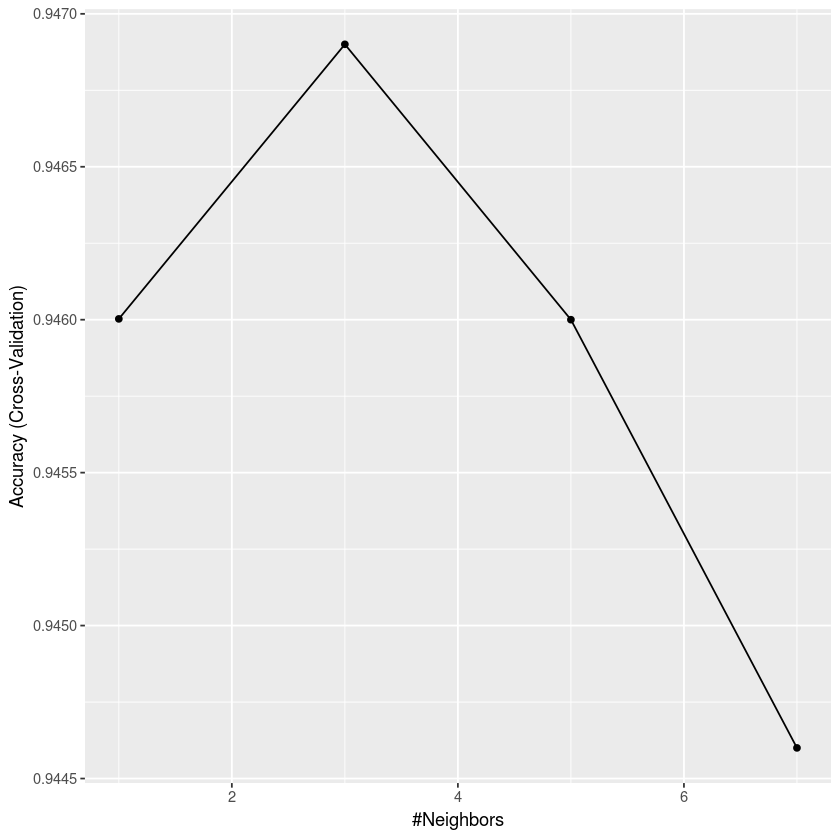

In [12]:
ggplot(train_knn)

In [13]:
n <- 1000
b <- 2
index <- sample(nrow(x),n)
control <- trainControl(method = 'cv', number = b, p = 0.9)
train_knn <- train(x[index,col_index],y[index],
                  method = 'knn',
                  tuneGrid = data.frame(k=c(3,5,7)),
                  trControl = control)

In [14]:
fit_knn <- knn3(x[,col_index],y,k=3)
y_hat_knn <- predict(fit_knn,
                    x_test[,col_index],
                    type='class')
cm <- confusionMatrix(y_hat_knn,factor(y_test))
cm$overall['Accuracy']

Accuracy 
   0.953

In [15]:
cm$byClass[,1:2]

,Sensitivity,Specificity
Class: 0,0.9800000,0.9966667
Class: 1,0.9906542,0.9910414
Class: 2,0.9223301,0.9977703
Class: 3,0.9431818,0.9945175
Class: 4,0.9189189,0.9966254
Class: 5,0.9591837,0.9933481
Class: 6,0.9895833,0.9966814
Class: 7,0.9791667,0.9911504
Class: 8,0.9072165,0.9977852
Class: 9,0.9423077,0.9921875


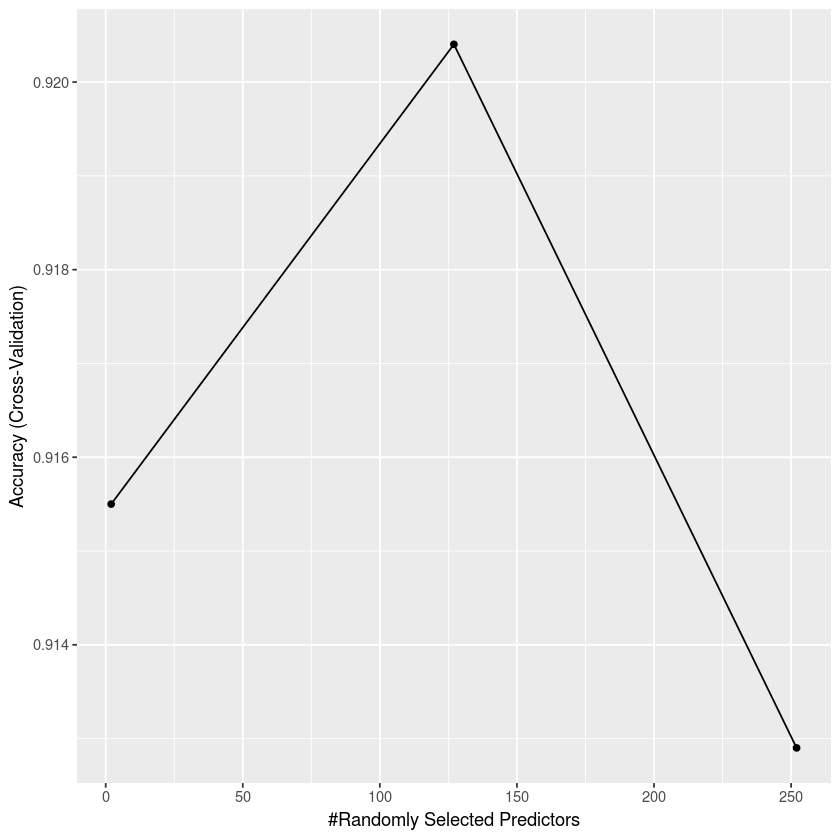

In [17]:
library(Rborist)
control <- trainControl(method='cv',number=5,p=0.8)
grid <- expand.grid(minNode=c(1,5),predFixed = c(10,15,25,35,50))

train_rf <- train(x[,col_index],
                 y,
                 method='Rborist',
                 nTree=50,
                 trControl=control,
                 trunGrid=grid,
                 nSamp=5000)

ggplot(train_rf)

In [18]:
train_rf$bestTune

,predFixed,minNode
2,127,2


In [19]:
fit_rf <- Rborist(x[,col_index],y,
                 nTree=1000,
                 minNode = train_rf$bestTune$minNode,
                 predFixed = train_rf$bestTune$predFixed)

In [21]:
y_hat_rf <- factor(levels(y)[predict(fit_rf,x_test[,col_index])$yPred])
cm <- confusionMatrix(y_hat_rf,y_test)
cm$overall['Accuracy']

Accuracy 
   0.949

In [26]:
library(randomForest)
x <- mnist$train$images[index,]
y <- factor(mnist$train$labels[index])
rf <- randomForest(x,y,ntree=50)
imp <- importance(rf)
imp

,MeanDecreaseGini
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0
10,0


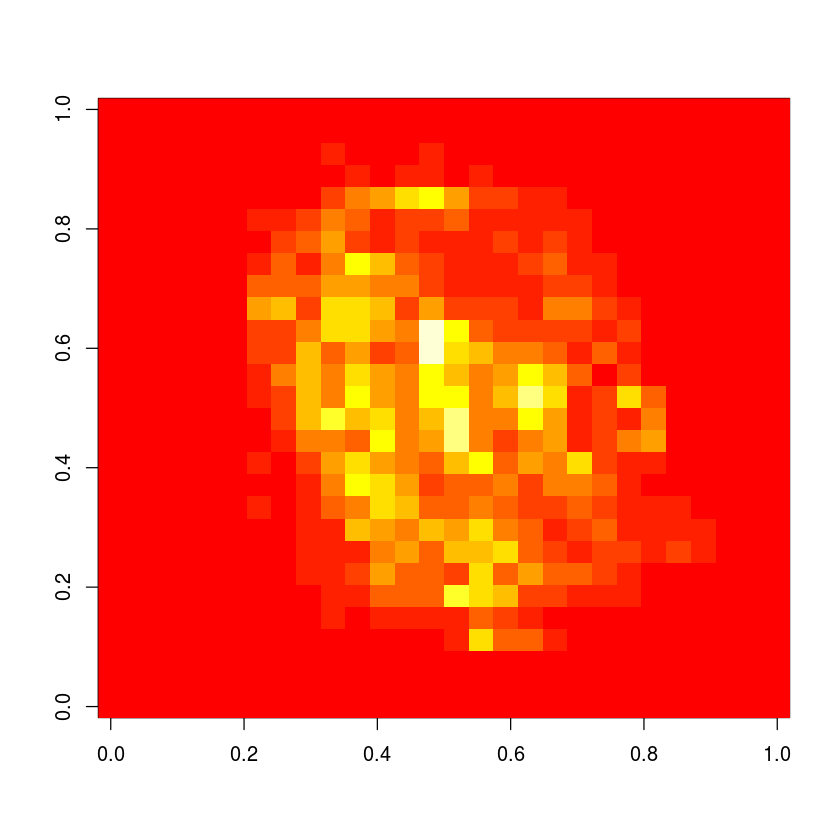

In [27]:
image(matrix(imp,28,28))

In [30]:
p_max <- predict(fit_knn,x_test[,col_index])
p_max <- apply(p_max,1,max)
ind <- which(y_hat_knn != y_test)
ind <- ind[order(p_max[ind],decreasing=TRUE)]

In [32]:
p_rf <- predict(fit_rf,x_test[,col_index])$census
p_rf <- p_rf / rowSums(p_rf)
p_knn <- predict(fit_knn,x_test[,col_index])
p <- (p_rf + p_knn)/2
y_pred <- factor(apply(p,1,which.max)-1)
confusionMatrix(y_pred,y_test)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3   4   5   6   7   8   9
         0  99   0   1   1   1   0   0   0   0   0
         1   0 106   2   0   3   0   0   1   1   0
         2   0   0  97   3   0   0   0   0   1   0
         3   0   0   0  84   0   1   0   0   2   0
         4   0   0   0   0 103   0   1   0   0   1
         5   0   0   0   0   0  94   0   0   1   2
         6   0   0   0   0   0   1  95   0   0   0
         7   0   0   3   0   1   0   0  94   0   2
         8   0   0   0   0   0   1   0   0  92   0
         9   1   1   0   0   3   1   0   1   0  99

Overall Statistics
                                          
               Accuracy : 0.963           
                 95% CI : (0.9494, 0.9738)
    No Information Rate : 0.111           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9589          
 Mcnemar's Test P-Value : NA              

Statistics by Class:
